In [29]:
import geopandas as gpd
from shapely.ops import polygonize
import matplotlib.pyplot as plt
import folium
import momepy as mm # outputs a 'TqdmWarning'

In [31]:
#only for development - to stop DeprecationWarnings from poping up
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
#loading data from file
mad = gpd.read_file('/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg')
mad.set_index(['u', 'v', 'key'], inplace=True)
mad.head(3)

osmid  oneway lanes                name  \
u      v          key                                                
171946 26513145   0    807334397    True     4  Calle de Velázquez   
       3280496563 0    807334397    True     4  Calle de Velázquez   
       1209330272 0    321307751    True   nan  Calle de Velázquez   

                           highway maxspeed reversed  length        from  \
u      v          key                                                      
171946 26513145   0       tertiary       50    False  41.093      171946   
       3280496563 0       tertiary       50    False  30.852  3280496563   
       1209330272 0    residential      nan    False  32.461  1209330272   

                             to junction bridge  ref access tunnel width  \
u      v          key                                                      
171946 26513145   0    26513145     None    nan  nan    nan    nan  None   
       3280496563 0      171946     None    nan  nan    nan    nan  None   
       1209330272 0      171946     None    nan  nan    nan    nan  None   

                      landuse est_width  \
u      v          key                     
171946 26513145   0      None      None   
       3280496563 0      None      None   
       1209330272 0      None      None   

                                                                geometry  
u      v          key                                                     
171946 26513145   0    LINESTRING (600247.796 646721.109, 600250.422 ...  
       3280496563 0    LINESTRING (600242.659 646690.974, 600244.482 ...  
       1209330272 0    LINESTRING (600265.192 646697.507, 600261.267 ...

<AxesSubplot:>

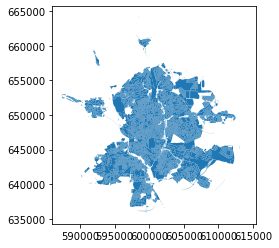

In [6]:
mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry = [g for g in mad_polys], crs= mad.crs)
mad_polys.plot()

In [12]:
import rabs_simplify as rabs

In [19]:
#using this to reload module for debugging
import importlib
importlib.reload(rabs_simplify)

<module 'rabs_simplify' from '/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/rabs_simplify.py'>

In [20]:
#the overall function seems to work
mad_simplrab = rabs.roundabout_simpl(mad, mad_polys)


/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
m = mad_simplrab.explore(tiles = 'CartoDB dark_matter', color='red', name='new edges')
mad.explore(m=m, color= 'white', name='original edges')

#run only when simplified step by step (i.e. not in combined function)
rab.explore(m=m , color='yellow', name = 'roundabouts') 

folium.LayerControl().add_to(m)  # layer control
m

In [22]:
#but to undesrtand it piece by piece I run it individually
rab = rabs.selecting_rabs_from_poly(mad_polys, circom_threshold = 0.7)
rab_plus = rabs.rabs_center_points(rab, center_type = 'centroid')
incoming_all = rabs.selecting_incoming_lines(rab_plus, mad, angle_threshold=0)
output = rabs.ext_lines_to_center(mad, incoming_all, rab_plus)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [24]:
print('Number of roundabouts modified:')
len(rab_plus)

Number of roundabouts modified:


692

## to develop/ analyse
- further analysis to see if the current code works for smaller RABS and not so much for bigger ones
- what's such threshold ?
- what/how to better select adjacent areas ?
    -idea: limit to an extent that's futher that the radius(buffer) of the area

In [39]:
#recreating some attributes to see if size and compactness drive patterns of errors
or_rabs = rab[rab.index == rab.index_right]
or_rabs['area'] = or_rabs.geometry.area
or_rabs["circom"] = mm.CircularCompactness(or_rabs, "area").series
or_rabs.tail(3)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,index_right,area,circom
15820,"POLYGON ((599310.998 656796.065, 599307.324 65...",15820,565.396701,0.977952
15848,"POLYGON ((602865.024 656746.199, 602869.344 65...",15848,1608.790869,0.977934
15852,"POLYGON ((592098.635 643109.424, 592098.226 64...",15852,257.479120,0.970399


In [51]:
#how many adjacent polygons where picked up by each round about
or_rabs['adjacent_polys'] = rab.groupby('index_right')['index_right'].count()-1
or_rabs.head(3)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,index_right,area,circom,adjacent_polys
356,"POLYGON ((599895.357 645441.472, 599897.468 64...",356,382.110071,0.970240,0
3573,"POLYGON ((599610.333 645290.707, 599602.380 64...",3573,4152.348962,0.987128,1
26,"POLYGON ((607717.202 647660.853, 607713.722 64...",26,9791.985128,0.945734,5


<AxesSubplot:title={'center':'area'}, xlabel='[adjacent_polys]'>

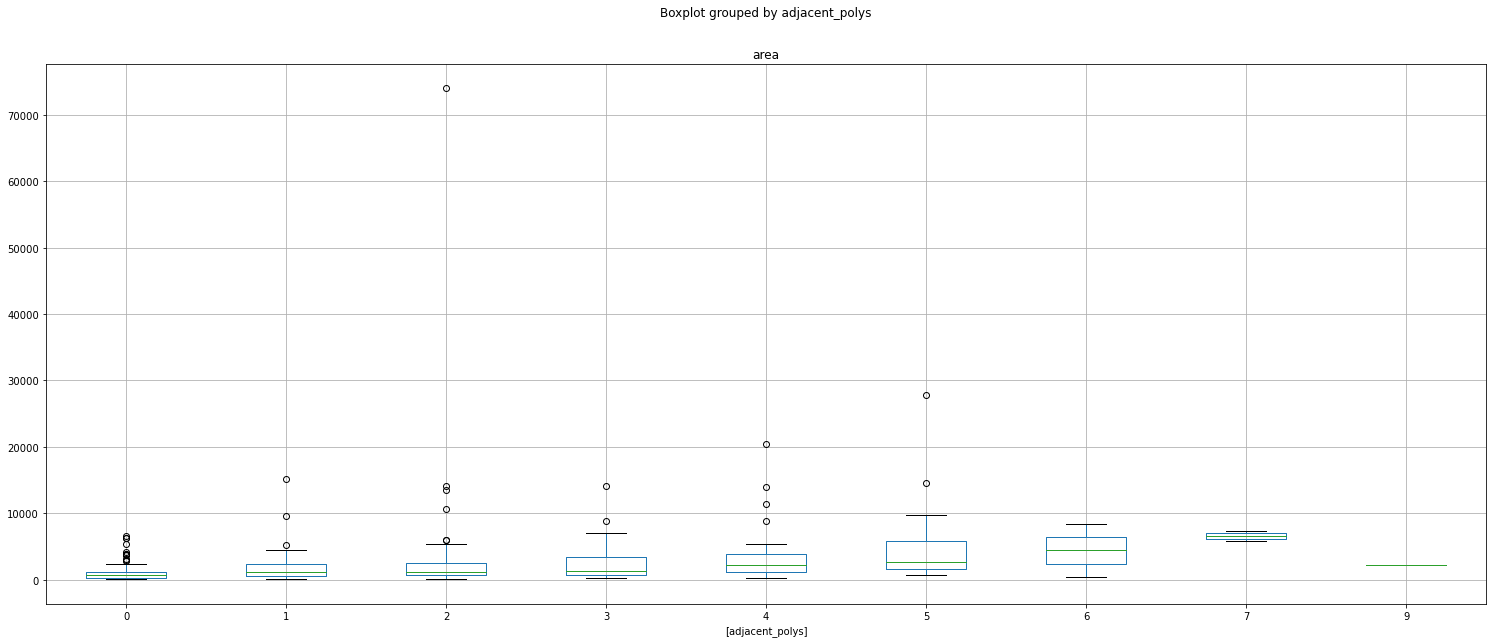

In [56]:
#plotting area vs number of 
or_rabs.boxplot(figsize = (25,10),column=['area'], by = ['adjacent_polys'])

<AxesSubplot:xlabel='adjacent_polys'>

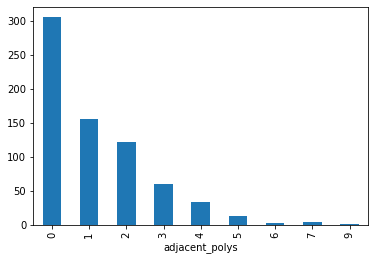

In [62]:
s = or_rabs.groupby('adjacent_polys')['index_right'].count()
s.plot.bar()

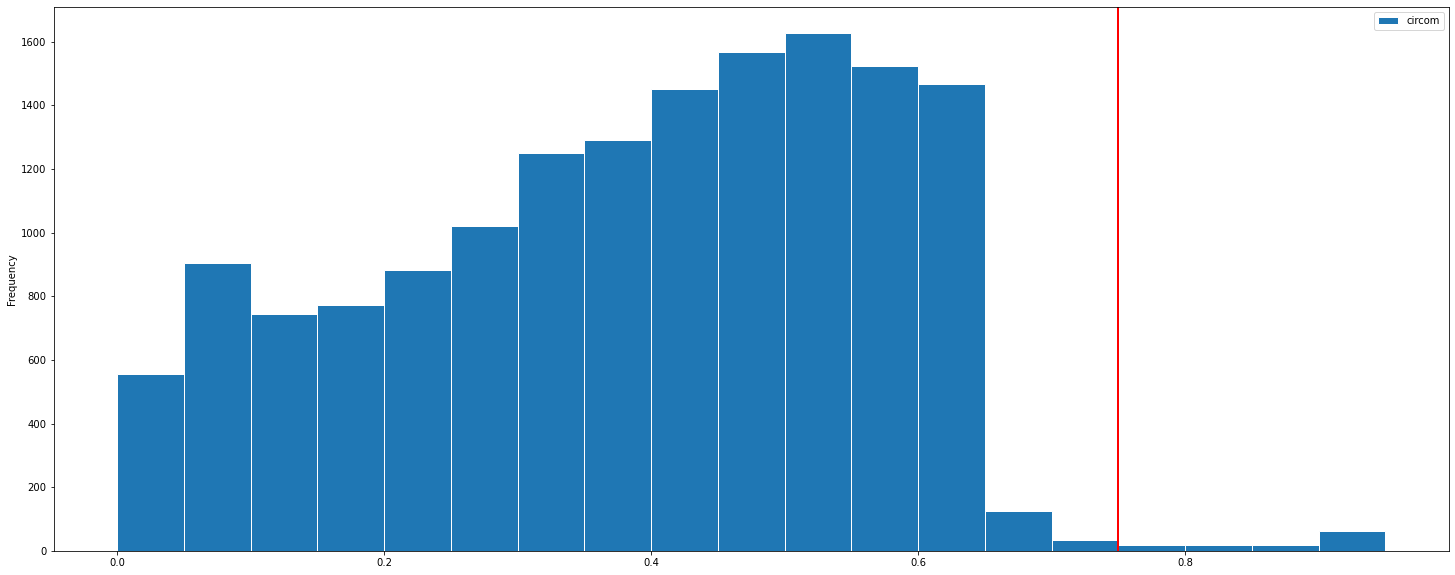

In [125]:
#testing better thresholds for circom
thr = 0.75
mybins= [x/100 for x in range(0, 100, 5)]

mad_polys.plot.hist(column = 'circom', bins = mybins, figsize = (25,10), edgecolor= 'white')
plt.axvline(thr, color='red', linewidth=2)


<AxesSubplot:>

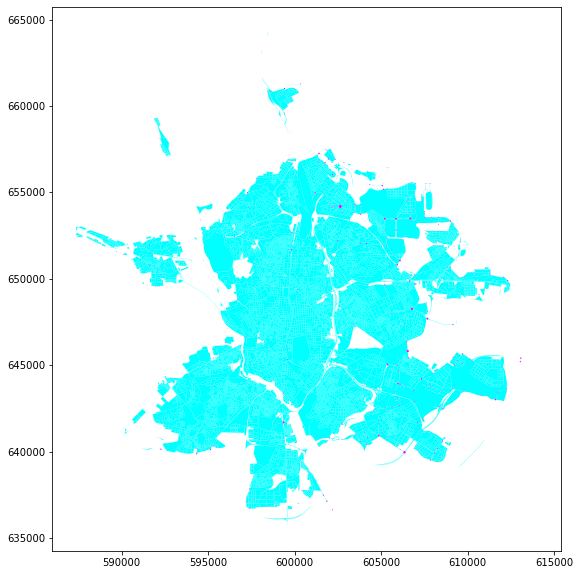

In [137]:
mad_polys['above_075'] = mad_polys.circom > 0.75
mad_polys['above_080'] = mad_polys.circom > 0.8

mad_polys.plot(column ='above_080', figsize = (25,10), cmap = 'cool')

